In [ ]:
# 合并后的数据集
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("filter/merged_hpv.csv")
features = ['Chr', 'Start', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']


x_train_all, x_valid_all, y_train, y_valid = train_test_split(df, df.iloc[:, 0], test_size=0.3, random_state=0)

# only need some features as input of classifier
x_train = x_train_all[features]
x_valid = x_valid_all[features]

In [ ]:
print(df.shape)
print(x_train_all["True Label"].value_counts())
print(x_valid_all["True Label"].value_counts())
print(x_train_all.shape)
print(x_valid_all.shape)

In [ ]:
# 调参后，分类器使用最优参数
from lightgbm.sklearn import LGBMClassifier

num_leaves = 48
# num_leaves = 29
n_estimators = 100
max_depth = 8
learning_rate = 0.05
early_stopping_rounds = 10
num_round = 700


# print(x_train.shape, x_valid.shape, x_test.shape, y_test.shape, y_valid.shape, y_test.shape)
# optimized_classifier = LGBMClassifier(boosting="gbdt", objective='binary', num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, is_unbalance=True, num_round=num_round, metrics='auc', max_bin=100)
optimized_classifier = LGBMClassifier(boosting="gbdt", num_leaves=100, max_depth=8, learning_rate=0.03, n_estimators=150, metrics='auc', min_child_samples=20, min_child_weight=0.001, bagging_fraction=0.6, feature_fraction=0.5, reg_alpha=0.08, reg_lambda=0.3, num_round=50, early_stopping_rounds=50)
# optimized_classifier.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], categorical_feature=["Chr", "Ref", "Alt", "A_Ref", "A_Alt"], early_stopping_rounds=early_stopping_rounds)
optimized_classifier.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], categorical_feature=["Chr", "A_Ref", "A_Alt"], early_stopping_rounds=early_stopping_rounds)
optimized_classifier

In [ ]:
print(optimized_classifier.feature_importances_)
print(optimized_classifier.feature_name_)

from matplotlib import pyplot as plt
import numpy as np
# max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
# importances = optimized_classifier.feature_importances_.apply(max_min_scaler)


fig = plt.figure(figsize=(12,4))

min_ = np.sum(optimized_classifier.feature_importances_)
max_ = np.max(optimized_classifier.feature_importances_)
importances = (optimized_classifier.feature_importances_) / (min_)
print(importances)

plt.title("Importance of features used in our model")
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)

feature_names = optimized_classifier.feature_name_ 
feature_names[1] = "Location"
print(feature_names)
df = pd.DataFrame({"feature_name":feature_names, "importance": importances})
print(df)
df.sort_values("importance", ascending=False, inplace=True)
print(df)
plt.bar(df["feature_name"], df["importance"])

import pandas as pd

# plt.xticks(optimized_classifier.feature_name_, optimized_classifier.feature_name_, rotation='vertical')
plt.xticks(rotation=60)
# plt.show()
plt.savefig("features.png", dpi=300, bbox_inches = 'tight')

In [ ]:
# 在swissvar上比较不同分类器性能
import pandas as pd
import numpy as np

# features = ['Chr', 'Start', 'End', 'Ref', 'Alt', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']
features = ['Chr', 'Start', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']

labels = ["SIFT_Label", "Polyphen2_HDIV_Label", "Polyphen2_HVAR_Label", "LRT_Label", "MutationTaster_Label", "MutationAssessor_Label", "FATHMM_Label", "RadialSVM_Label", "VEST3_score", "CADD_phred"]

swissvar_test_all = pd.read_csv("filter/swissvar_with_labels.csv")
# swissvar_test_all = swissvar_test_all.dropna(subset=labels)
# swissvar_test_input = swissvar_test_all[features]

comparators = ['MCAP', 'REVEL', 'MVP_score','DANN_score', 'GERP++_RS']
swissvar_compare = swissvar_test_all.dropna(subset=comparators)
swissvar_input = swissvar_compare[features]

# 对分数做归一化
comparator_to_normalized = ["MCAP", 'GERP++_RS']

max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

for c in comparators:
    if c in comparator_to_normalized:
        swissvar_compare[c + "_normalized"] = swissvar_compare[[c]].apply(max_min_scaler)
    else:
        swissvar_compare[c + "_normalized"] = swissvar_compare[c]

In [ ]:
print(swissvar_compare["True Label"].value_counts())
print(swissvar_compare.shape)

In [ ]:
swissvar_output = optimized_classifier.predict_proba(swissvar_input)
swissvar_output = swissvar_output[:, 1]
swissvar_label = swissvar_compare["True Label"]

import sklearn.metrics as me
compare_classifiers = ["MCAP_normalized", "REVEL_normalized", "MVP_score_normalized", "DANN_score_normalized", "GERP++_RS_normalized"]
 
swissvar_probs = [swissvar_output, swissvar_compare["MCAP_normalized"], swissvar_compare["REVEL_normalized"], swissvar_compare["MVP_score_normalized"], swissvar_compare["DANN_score_normalized"]]

# 画roc曲线
import matplotlib.pyplot as plt

def draw_roc_curve_2(ax, label, pred_probs, classifiers):
    fpr_tpr_aucs = []
    for pred_prob in pred_probs:
        assert(len(pred_prob)==len(label))
        fpr, tpr, thres= me.roc_curve(label, pred_prob)
        auc = me.auc(fpr, tpr)
        fpr_tpr_aucs.append([fpr, tpr, auc])
    # fig, ax = plt.subplots(figsize=(10,8))
    # ax = plt.subplots(122)
    for i in range(len(fpr_tpr_aucs)):
        ax.plot(fpr_tpr_aucs[i][0], fpr_tpr_aucs[i][1], label='{} (AUC={})'.format(classifiers[i], str(round(fpr_tpr_aucs[i][2], 3))))
    #绘制对角线
    ax.plot([0,1],[0,1],linestyle='--',color='grey')
    #调整字体大小
    ax.legend(fontsize=12)
    ax.set_title("SwissVarSelected")
    # plt.savefig("result.png", dpi=1000, bbox_inches = 'tight')

classifers = ["proposed", "MCAP", "REVEL", "MVP", "DANN", "GERP++"]

draw_roc_curve(swissvar_label, swissvar_probs, classifers)

In [ ]:
import sklearn.metrics as me
compare_classifiers = ["MCAP_normalized", "REVEL_normalized", "MVP_score_normalized", "DANN_score_normalized", "GERP++_RS_normalized"]
 
# swissvar_probs = [swissvar_compare["MCAP_normalized"], swissvar_compare["REVEL_normalized"], swissvar_compare["MVP_score_normalized"], swissvar_compare["DANN_score_normalized"]]
swissvar_probs = [swissvar_output, swissvar_compare["MCAP_normalized"], swissvar_compare["REVEL_normalized"], swissvar_compare["MVP_score_normalized"], swissvar_compare["DANN_score_normalized"]]

def draw_precison_recall_curve(label, pred_probs, classifiers):
    prec_rec_pr = []
    for index, pred_prob in enumerate(pred_probs):
        assert(len(pred_prob)==len(label))
        prec, rec, thres= me.precision_recall_curve(label, pred_prob)
        if index == 1:
            print(np.where(prec==0))
            prec = np.delete(prec, [9327, 9328])
            rec =np.delete(rec, [9327, 9328])
            print(np.where(prec==0))
            print(np.where(prec==np.min(prec)))
            prec = np.delete(prec, [9326])
            rec =np.delete(rec, [9326])
            print(np.where(prec==np.min(prec)))
            prec = np.delete(prec, [9324])
            rec =np.delete(rec, [9324])
            print(np.where(prec==np.min(prec)))
            prec = np.delete(prec, [1])
            rec =np.delete(rec, [1])
            print(np.where(prec==np.min(prec)))
        prec_rec_pr.append([prec, rec])
        # plt.plot(rec, prec)
        
    fig, ax = plt.subplots(figsize=(10,8))
    for i in range(len(prec_rec_pr)):
        print(i)
        ax.plot(prec_rec_pr[i][1], prec_rec_pr[i][0], label='{}'.format(classifiers[i]))
    #绘制对角线
    # ax.plot([0,1],[0,1],linestyle='--',color='grey')
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    #调整字体大小
    plt.legend(fontsize=12)
    # plt.show()
    plt.savefig("12.png", dpi=1000, bbox_inches = 'tight')
classifers = ["proposed", "M-CAP", "REVEL", "MVP", "DANN"]

draw_precison_recall_curve(swissvar_label, swissvar_probs, classifers)

In [ ]:
# 在exovar上比较不同分类器性能
import pandas as pd
import numpy as np

# features = ['Chr', 'Start', 'End', 'Ref', 'Alt', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']
features = ['Chr', 'Start', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score','LRT_score', 'MutationTaster_score', 'MutationAssessor_score',  'FATHMM_score', 'RadialSVM_score', 'VEST3_score', 'CADD_phred', 'A_Ref', 'A_Alt']

labels = ["SIFT_Label", "Polyphen2_HDIV_Label", "Polyphen2_HVAR_Label", "LRT_Label", "MutationTaster_Label", "MutationAssessor_Label", "FATHMM_Label", "RadialSVM_Label", "VEST3_score", "CADD_phred"]

exovar_test_all = pd.read_csv("filter/ExoVarFiltered.hg19_multianno.csv")

comparators = ['MCAP', 'REVEL', 'MVP_score','DANN_score', 'GERP++_RS']
exovar_compare = exovar_test_all.dropna(subset=comparators)
exovar_input = exovar_compare[features]

# 对分数做归一化
comparator_to_normalized = ["MCAP", 'GERP++_RS']

max_min_scaler = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

for c in comparators:
    if c in comparator_to_normalized:
        exovar_compare[c + "_normalized"] = exovar_compare[[c]].apply(max_min_scaler)
    else:
        exovar_compare[c + "_normalized"] = exovar_compare[c]

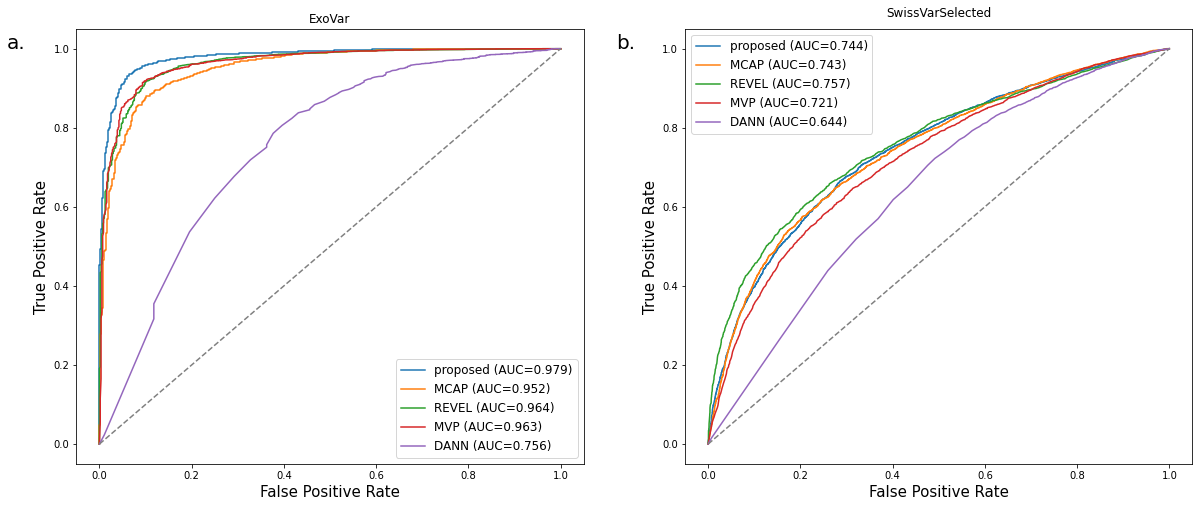

In [89]:
exovar_output = optimized_classifier.predict_proba(exovar_input)
exovar_output = exovar_output[:, 1]
exovar_label = exovar_compare["True Label"]

import sklearn.metrics as me
compare_classifiers = ["MCAP_normalized", "REVEL_normalized", "MVP_score_normalized", "DANN_score_normalized", "GERP++_RS_normalized"]
 
exovar_probs = [exovar_output, exovar_compare["MCAP_normalized"], exovar_compare["REVEL_normalized"], exovar_compare["MVP_score_normalized"], exovar_compare["DANN_score_normalized"]]

# 画roc曲线
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8))

def draw_roc_curve_1(ax, label, pred_probs, classifiers):
    fpr_tpr_aucs = []
    for pred_prob in pred_probs:
        assert(len(pred_prob)==len(label))
        fpr, tpr, thres= me.roc_curve(label, pred_prob)
        auc = me.auc(fpr, tpr)
        fpr_tpr_aucs.append([fpr, tpr, auc])
    # ax = plt.subplot(121)
    for i in range(len(fpr_tpr_aucs)):
        ax.plot(fpr_tpr_aucs[i][0], fpr_tpr_aucs[i][1], label='{} (AUC={})'.format(classifiers[i], str(round(fpr_tpr_aucs[i][2], 3))))
    #绘制对角线
    ax.plot([0,1],[0,1],linestyle='--',color='grey')
    ax.set_xlabel("False Positive Rate", fontsize=15)
    ax.set_ylabel("True Positive Rate", fontsize=15)
    ax.set_title("ExoVar")
    ax.text(-0.2, 1, "a.", fontsize=20)
    #调整字体大小
    ax.legend(fontsize=12)
    # plt.title("AUC performance of ")

def draw_roc_curve_2(ax, label, pred_probs, classifiers):
    fpr_tpr_aucs = []
    for pred_prob in pred_probs:
        assert(len(pred_prob)==len(label))
        fpr, tpr, thres= me.roc_curve(label, pred_prob)
        auc = me.auc(fpr, tpr)
        fpr_tpr_aucs.append([fpr, tpr, auc])
    # fig, ax = plt.subplots(figsize=(10,8))
    # ax = plt.subplots(122)
    for i in range(len(fpr_tpr_aucs)):
        ax.plot(fpr_tpr_aucs[i][0], fpr_tpr_aucs[i][1], label='{} (AUC={})'.format(classifiers[i], str(round(fpr_tpr_aucs[i][2], 3))))
    #绘制对角线
    ax.plot([0,1],[0,1],linestyle='--',color='grey')
    ax.set_xlabel("False Positive Rate", fontsize=15)
    ax.set_ylabel("True Positive Rate", fontsize=15)
    #调整字体大小
    ax.legend(fontsize=12)
    ax.set_title("SwissVarSelected", pad=12)
    ax.text(-0.2, 1, "b.", fontsize=20)
    # plt.savefig("result.png", dpi=1000, bbox_inches = 'tight')

classifers = ["proposed", "MCAP", "REVEL", "MVP", "DANN", "GERP++"]

draw_roc_curve_1(ax1, exovar_label, exovar_probs, classifers)
draw_roc_curve_2(ax2, swissvar_label, swissvar_probs, classifers)
plt.savefig("result.png", dpi=1000, bbox_inches = 'tight')

In [ ]:
import sklearn.metrics as me
compare_classifiers = ["MCAP_normalized", "REVEL_normalized", "MVP_score_normalized", "DANN_score_normalized", "GERP++_RS_normalized"]
 
# swissvar_probs = [swissvar_compare["MCAP_normalized"], swissvar_compare["REVEL_normalized"], swissvar_compare["MVP_score_normalized"], swissvar_compare["DANN_score_normalized"]]
exovar_probs = [exovar_output, exovar_compare["MCAP_normalized"], exovar_compare["REVEL_normalized"], exovar_compare["MVP_score_normalized"], exovar_compare["DANN_score_normalized"]]


def draw_precison_recall_curve(label, pred_probs, classifiers):
    prec_rec_pr = []
    for pred_prob in pred_probs:
        assert(len(pred_prob)==len(label))
        prec, rec, thres= me.precision_recall_curve(label, pred_prob)
        prec_rec_pr.append([prec, rec])
    ax = plt.subplots(121)
    for i in range(len(prec_rec_pr)):
        print(i)
        ax.plot(prec_rec_pr[i][1], prec_rec_pr[i][0], label='{}'.format(classifiers[i]))
    #绘制对角线
    # ax.plot([0,1],[0,1],linestyle='--',color='grey')
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    #调整字体大小
    plt.legend(fontsize=12)
    # plt.show()
    plt.savefig("12.png", dpi=1000, bbox_inches = 'tight')
classifers = ["proposed", "M-CAP", "REVEL", "MVP", "DANN"]

# draw_precison_recall_curve(exovar_label, exovar_probs, classifers)
draw_roc_curve(swissvar_label, swissvar_probs, classifers)